# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла.<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Лузин".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* В Mini Batch SGD - по подвыборке объектов, т.е. в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Считать градиент по мини батчам
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом).

# Реализация модели

## Имплементация (6 баллов)

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss
from sklearn.utils import gen_batches

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, batch_size=100, shuffle=True, random_state=None, verbose=0, class_weight=None):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_state = random_state
        self.verbose = verbose
        self.class_weight = class_weight
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        
        self.classes = np.empty(2)
        self.classes[:] = np.unique(y)
        np.random.seed(self.random_state)
        if self.shuffle:
            order = range(X.shape[0])
            np.random.shuffle(order)
            X, y = X[order], y[order]
        if self.class_weight is None:
            self.class_weight = {self.classes[0]: -1, self.classes[1]: 1}
        sample_weight = np.vectorize(self.class_weight.get)(y)
        self.coef_ = np.zeros(X.shape[1])
        self.intercept_ = np.zeros(1)
        for n_epoch in xrange(self.max_epoch):
            for n_batch, idx_slice in enumerate(gen_batches(X.shape[0], self.batch_size)):
                beta = np.hstack((self.intercept_, self.coef_))
                self.intercept_, self.coef_ = np.split(beta - self.alpha / (n_epoch + 1.) * (pow(self.C, -1) * 2 * beta - np.dot(sample_weight[idx_slice] * np.power(1 + np.exp(sample_weight[idx_slice] * (np.dot(X[idx_slice], self.coef_) + self.intercept_[0])), -1), np.hstack((np.ones((idx_slice.stop - idx_slice.start, 1)), X[idx_slice])))), (len(self.intercept_),))
                if self.verbose > 1:
                    print '-- Batch {}'.format(n_batch)
                    print 'Avg. loss: {}'.format(log_loss(y, self.predict_proba(X)[:, 1]))
            if self.verbose > 0:
                print '-- Epoch {}'.format(n_epoch)
                print 'Avg. loss: {}'.format(log_loss(y, self.predict_proba(X)[:, 1]))
        return self
    
    def partial_fit(self, X, y=None, classes=None, sample_weight=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        
        try:
            self.classes
        except AttributeError:
            self.classes = np.empty(2)
            if classes is None:
                self.classes[:] = np.unique(y)
            else:
                self.classes[:] = classes
            self.n_iter = 0
            np.random.seed(self.random_state)
        if self.shuffle:
            order = range(X.shape[0])
            np.random.shuffle(order)
            X, y = X[order], y[order]
        if self.class_weight is None:
            self.class_weight = {self.classes[0]: -1, self.classes[1]: 1}
        if sample_weight is None:
            sample_weight = np.vectorize(self.class_weight.get)(y)
        try:
            self.intercept_, self.coef_
        except AttributeError:
            self.coef_ = np.zeros(X.shape[1])
            self.intercept_ = np.zeros(1)
        for n_batch, idx_slice in enumerate(gen_batches(X.shape[0], self.batch_size)):
            beta = np.hstack((self.intercept_, self.coef_))
            self.intercept_, self.coef_ = np.split(beta - self.alpha / (self.n_iter + 1.) * (pow(self.C, -1) * 2 * beta - np.dot(sample_weight[idx_slice] * np.power(1 + np.exp(sample_weight[idx_slice] * (np.dot(X[idx_slice], self.coef_) + self.intercept_[0])), -1), np.hstack((np.ones((idx_slice.stop - idx_slice.start, 1)), X[idx_slice])))), (len(self.intercept_),))
            if self.verbose > 1:
                print '-- Batch {}'.format(n_batch)
                print 'Avg. loss: {}'.format(log_loss(y, self.predict_proba(X)[:, 1]))
        if self.verbose > 0:
            print '-- Epoch {}'.format(self.n_iter)
            print 'Avg. loss: {}'.format(log_loss(y, self.predict_proba(X)[:, 1]))
        self.n_iter += 1
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        
        y_hat = self.classes[np.argmax(self.predict_proba(X), axis=1)]
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''

        y_hat_proba = np.power(1 + np.exp(-np.dot(np.transpose([np.dot(X, self.coef_) + self.intercept_[0]]), [self.class_weight.values()])), -1)
        return y_hat_proba

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

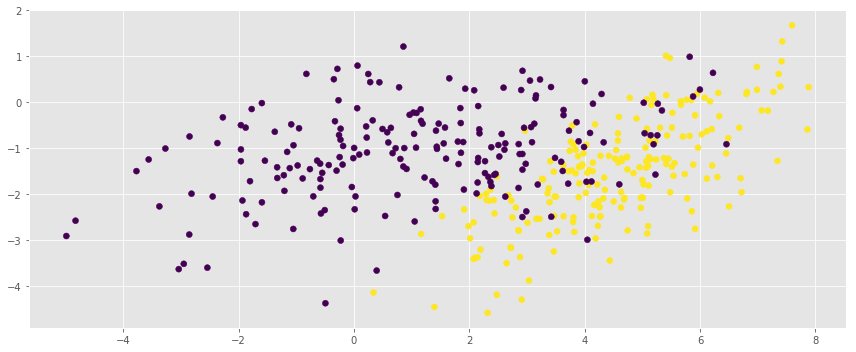

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)
plt.tight_layout()

In [5]:
model = MySGDClassifier(max_epoch=1000)
model.fit(X, y)

MySGDClassifier(C=1, alpha=0.01, batch_size=100,
        class_weight={0.0: -1, 1.0: 1}, max_epoch=1000, random_state=None,
        shuffle=True, verbose=0)

In [6]:
y_pred = model.predict(X)
y_pred

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [7]:
y_proba = model.predict_proba(X)
y_proba[:100]

array([[ 0.11608053,  0.88391947],
       [ 0.05666348,  0.94333652],
       [ 0.21364312,  0.78635688],
       [ 0.18411002,  0.81588998],
       [ 0.18399233,  0.81600767],
       [ 0.10568068,  0.89431932],
       [ 0.17029481,  0.82970519],
       [ 0.16696449,  0.83303551],
       [ 0.16543681,  0.83456319],
       [ 0.28576547,  0.71423453],
       [ 0.28773235,  0.71226765],
       [ 0.24252524,  0.75747476],
       [ 0.23894231,  0.76105769],
       [ 0.23067966,  0.76932034],
       [ 0.07241136,  0.92758864],
       [ 0.1754871 ,  0.8245129 ],
       [ 0.51367155,  0.48632845],
       [ 0.21786269,  0.78213731],
       [ 0.08989203,  0.91010797],
       [ 0.26610298,  0.73389702],
       [ 0.44854286,  0.55145714],
       [ 0.13385829,  0.86614171],
       [ 0.28821775,  0.71178225],
       [ 0.20506878,  0.79493122],
       [ 0.33073217,  0.66926783],
       [ 0.22361528,  0.77638472],
       [ 0.37860129,  0.62139871],
       [ 0.17928023,  0.82071977],
       [ 0.18546606,

In [8]:
model.intercept_, model.coef_

(array([-1.81809494]), array([ 0.56154841, -0.36570231]))

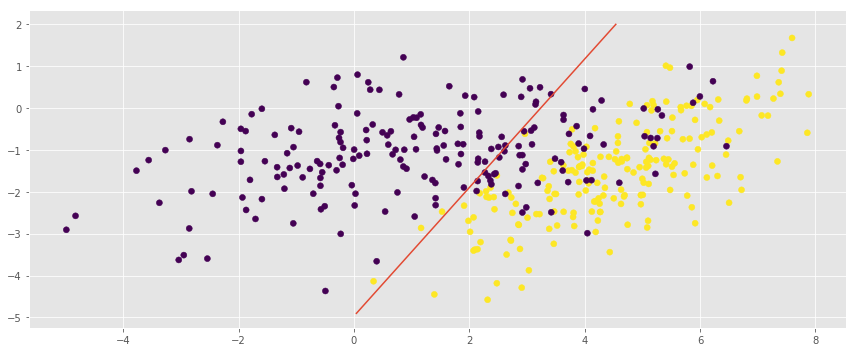

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.plot(-(model.coef_[1] / model.coef_[0] * np.asarray(plt.ylim()) + model.intercept_[0] / model.coef_[0]), plt.ylim())
plt.tight_layout()

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

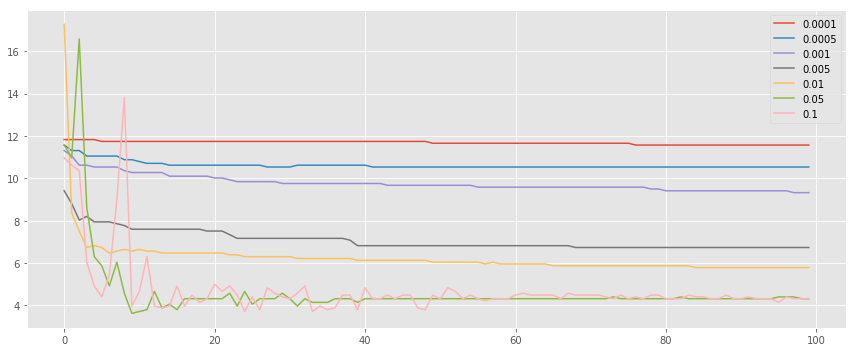

In [10]:
def demo_loss(alpha):
    clf = MySGDClassifier(alpha=alpha, max_epoch=100)
    y_score = []
    for n_iter in xrange(clf.max_epoch):
        clf.partial_fit(X, y)
        y_score.append(log_loss(y, clf.predict(X)))
    plt.plot(xrange(clf.max_epoch), y_score)

alpha_range = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
for alpha in alpha_range:
    demo_loss(alpha)
plt.legend(alpha_range)
plt.tight_layout()

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная онлайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в hearthstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**.

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [11]:
# Загрузка данных целиком
df_list = []
for chunk in range(1,5):
    filepath = './trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))

df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = './trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')

In [12]:
df_data.shape

(2000000, 45)

In [13]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [14]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [15]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.5047995

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [16]:
player_unique_hero_card_id = np.unique(df_data.player_hero_card_id)
len(player_unique_hero_card_id)

9

In [17]:
opponent_unique_hero_card_id = np.unique(df_data.opponent_hero_card_id)
len(opponent_unique_hero_card_id)

9

In [18]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(dtype=int, sparse=False)
y_transform = enc.fit_transform(df_data.opponent_hero_card_id.values.reshape(-1, 1))
df_transform = pd.DataFrame(y_transform, index=df_data.index)
df_transform.columns = ['opponent_hero_card_id{}'.format(value) for value in opponent_unique_hero_card_id]
df_data = pd.concat((df_data.drop('opponent_hero_card_id', axis='columns'), df_transform), axis=1)
y_transform = enc.fit_transform(df_data.player_hero_card_id.values.reshape(-1, 1))
df_transform = pd.DataFrame(y_transform, index=df_data.index)
df_transform.columns = ['player_hero_card_id{}'.format(value) for value in player_unique_hero_card_id]
df_data = pd.concat((df_data.drop('player_hero_card_id', axis='columns'), df_transform), axis=1)
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


## Обучение модели (1 балл)

#### Задание

* Получите матрицу-объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [19]:
X = np.asarray(df_data.drop('decision', axis='columns'), dtype=float)
y = np.asarray(df_data.decision)
for idx in xrange(X.shape[1]):
    X[:, idx] = (X[:, idx] - X[:, idx].mean()) / X[:, idx].std()
X, y

(array([[ 1.16292076, -0.25878141, -0.2706061 , ..., -0.36326289,
          2.88049005, -0.37853876],
        [-0.39967732, -0.25878141, -0.2706061 , ..., -0.36326289,
         -0.34716315, -0.37853876],
        [-0.84613392,  2.56170396, -0.2706061 , ..., -0.36326289,
         -0.34716315, -0.37853876],
        ..., 
        [-1.06936221, -0.25878141, -0.2706061 , ..., -0.36326289,
         -0.34716315, -0.37853876],
        [ 0.71646417,  2.56170396, -0.2706061 , ..., -0.36326289,
         -0.34716315, -0.37853876],
        [-0.62290562, -0.25878141, -0.2706061 , ..., -0.36326289,
          2.88049005, -0.37853876]]), array([1, 1, 1, ..., 0, 0, 0]))

In [20]:
clf = MySGDClassifier(alpha=0.05, max_epoch=100, batch_size=10, verbose=1)
clf.fit(X, y)

-- Epoch 0
Avg. loss: 0.838431425832
-- Epoch 1
Avg. loss: 0.631623254563
-- Epoch 2
Avg. loss: 0.607248214142
-- Epoch 3
Avg. loss: 0.59904745508
-- Epoch 4
Avg. loss: 0.594970811726
-- Epoch 5
Avg. loss: 0.592422065309
-- Epoch 6
Avg. loss: 0.59058380009
-- Epoch 7
Avg. loss: 0.589135749153
-- Epoch 8
Avg. loss: 0.587933518525
-- Epoch 9
Avg. loss: 0.586904756186
-- Epoch 10
Avg. loss: 0.586009314856
-- Epoch 11
Avg. loss: 0.585222344084
-- Epoch 12
Avg. loss: 0.584526703843
-- Epoch 13
Avg. loss: 0.583909446883
-- Epoch 14
Avg. loss: 0.583360142978
-- Epoch 15
Avg. loss: 0.582870051518
-- Epoch 16
Avg. loss: 0.582431688089
-- Epoch 17
Avg. loss: 0.582038575461
-- Epoch 18
Avg. loss: 0.581685082318
-- Epoch 19
Avg. loss: 0.581366305452
-- Epoch 20
Avg. loss: 0.581077975304
-- Epoch 21
Avg. loss: 0.580816375792
-- Epoch 22
Avg. loss: 0.580578274323
-- Epoch 23
Avg. loss: 0.580360860023
-- Epoch 24
Avg. loss: 0.580161689133
-- Epoch 25
Avg. loss: 0.579978636839
-- Epoch 26
Avg. loss: 0

MySGDClassifier(C=1, alpha=0.05, batch_size=10,
        class_weight={0.0: -1, 1.0: 1}, max_epoch=100, random_state=None,
        shuffle=True, verbose=1)

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [21]:
df = pd.read_csv('./testData_tabular.csv', sep=',')
df_test = df
df_test.head()

,gamestate_id,decision,turn,opponent.armor,opponent.attack,opponent.hero_card_id,opponent.hp,opponent.special_skill_used,opponent.weapon_durability,opponent.crystals_all,...,player.played.hp_current,player.played.hp_max,player.hand.nOfMinions,player.hand.nOfSpells,player.hand.nOfWeapons,player.hand.nOfCards,player.hand.nOfPlayable,player.hand.attack,player.hand.crystals_cost,player.hand.hp
0,6845857.0,NaN,12,0,0,798,29,1,0,10,...,3,5,5,0,0,5,5,16,17,20
1,9279433.0,NaN,6,0,0,326,12,0,0,5,...,15,15,3,2,0,5,0,16,28,19
2,6642076.0,NaN,14,0,0,390,12,0,0,10,...,9,19,2,1,0,3,3,7,10,7
3,9169516.0,NaN,7,0,0,798,30,0,0,6,...,7,7,4,2,0,6,6,13,20,15
4,8991397.0,NaN,9,0,0,326,30,1,0,8,...,3,3,2,1,0,3,3,9,15,7


In [22]:
df_test.columns = df_test.columns.str.replace('.', '_')
df_test = df_test.set_index('gamestate_id')
y_transform = enc.fit_transform(df_test.opponent_hero_card_id.values.reshape(-1, 1))
df_transform = pd.DataFrame(y_transform, index=df_test.index)
df_transform.columns = ['opponent_hero_card_id{}'.format(value) for value in opponent_unique_hero_card_id]
df_test = pd.concat((df_test.drop('opponent_hero_card_id', axis='columns'), df_transform), axis=1)
y_transform = enc.fit_transform(df_test.player_hero_card_id.values.reshape(-1, 1))
df_transform = pd.DataFrame(y_transform, index=df_test.index)
df_transform.columns = ['player_hero_card_id{}'.format(value) for value in player_unique_hero_card_id]
df_test = pd.concat((df_test.drop('player_hero_card_id', axis='columns'), df_transform), axis=1)
df_test.head().T

gamestate_id,6845857.0,9279433.0,6642076.0,9169516.0,8991397.0
decision,NaN,NaN,NaN,NaN,NaN
turn,12.0,6.0,14.0,7.0,9.0
opponent_armor,0.0,0.0,0.0,0.0,0.0
opponent_attack,0.0,0.0,0.0,0.0,0.0
opponent_hp,29.0,12.0,12.0,30.0,30.0
opponent_special_skill_used,1.0,0.0,0.0,0.0,1.0
opponent_weapon_durability,0.0,0.0,0.0,0.0,0.0
opponent_crystals_all,10.0,5.0,10.0,6.0,8.0
opponent_crystals_current,8.0,5.0,0.0,6.0,2.0
opponent_deck_count,16.0,22.0,11.0,20.0,19.0


In [23]:
X_test = np.asarray(df_test.drop('decision', axis='columns'), dtype=float)
for idx in xrange(X_test.shape[1]):
    X_test[:, idx] = (X_test[:, idx] - X_test[:, idx].mean()) / X_test[:, idx].std()
y_pred = clf.predict(X_test)
df.decision = y_pred
df.decision.head()

0    0.0
1    1.0
2    1.0
3    0.0
4    0.0
Name: decision, dtype: float64

In [24]:
y_proba = clf.predict_proba(X_test)
np.savetxt('testData_submission.csv', y_proba[:, 1:], delimiter=',')

In [25]:
df_leaderboard = pd.DataFrame([{'Participant': 'luzin', 'Score': 0.7895, 'Submission date': '2017-05-02 23:33:51'}], index=[69])
df_leaderboard.columns.name = 'Place'
df_leaderboard.head()

Place,Participant,Score,Submission date
69,luzin,0.7895,2017-05-02 23:33:51
